<a href="https://colab.research.google.com/github/NadiaCarvalho/Motiv-Dataset/blob/main/Dataset_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Algorithms

In [1]:
#@title Dimensional Reduction Algorithms

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, Isomap, LocallyLinearEmbedding

def get_dimensionality_reduction(algorithm, latent_spaces, n_components=2):
  """
  Returns the dimensionality reduction of a shape.

  Parameters
  ----------
  algorithm : str
    Algorithm to use ('pca', 'tsne', 'mds', 'isomap', 'lle', 'umap').

  latent_spaces : np.array
    Shape N X T.

  n_components : int
    Number of components to reduce to.

  Returns
  -------
  np.array
    N X M array in which each element is a dimensionality reduction.
  """
  if algorithm == 'pca':
    from sklearn.preprocessing import StandardScaler
    pca = PCA(n_components=n_components)
    predictions = pca.fit_transform(
        StandardScaler().fit_transform(latent_spaces))
  elif algorithm == 'tsne':
    tsne = TSNE(n_components=n_components, perplexity=30 if len(latent_spaces) > 30 else len(latent_spaces)-1)
    predictions = tsne.fit_transform(np.asarray(latent_spaces))
  elif algorithm == 'mds':
    mds = MDS(n_components=n_components, normalized_stress="auto", max_iter=100)
    predictions = mds.fit_transform(latent_spaces)
  elif algorithm == 'isomap':
    iso = Isomap(n_components=n_components)
    predictions = iso.fit_transform(latent_spaces)
  elif algorithm == 'lle':
    lle = LocallyLinearEmbedding(n_components=n_components)
    predictions = lle.fit_transform(latent_spaces)
  else:
    try:
      import umap
    except ImportError:
      !pip install umap-learn
      import umap
    reducer = umap.UMAP(n_components=n_components)
    predictions = reducer.fit_transform(latent_spaces)
  return predictions

In [2]:
#@title Algorithms Correlation and Isometry / Distance Metrics
"""
Symmetry can often be analyzed by checking if one shape can be mapped to the other using an isometry,
which preserves distances between points.
To do this, you would look for transformations that do not distort distances,
such as translations, rotations, reflections, or their combinations.

Metrics to use:

Correlation Map:

Euclidean distance: You can compute the Euclidean distance between corresponding points on the shapes.
If the shapes are symmetric, the distance metric should remain invariant under the transformation.

Procrustes Analysis: This is a statistical method that allows you to compare two shapes by translating,
rotating, and scaling them to minimize the distance between them.
The amount of residual error left after this process can indicate symmetry.
"""

import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial import procrustes
from scipy.stats import pearsonr

def generate_correlation_map(x, y):
    """
    Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.
    """
    mu_x = x.mean(1)
    mu_y = y.mean(1)
    n = x.shape[1]
    if n != y.shape[1]:
        raise ValueError('x and y must ' +
                         'have the same number of timepoints.')
    s_x = x.std(1, ddof=n - 1)
    s_y = y.std(1, ddof=n - 1)
    cov = np.dot(x,
                 y.T) - n * np.dot(mu_x[:, np.newaxis],
                                  mu_y[np.newaxis, :])
    return cov / np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :])

def get_correlation_coefficient(shape1, shape2):
  """
  Returns the correlation coefficient
  between two shapes.

  Parameters
  ----------
  shape1 : np.array
    Shape N X T.

  shape2 : np.array
    Shape M X T.

  Returns
  -------
  float
    Correlation coefficient between the two shapes.
  """
  return pearsonr(np.asarray(shape1).flatten(), np.asarray(shape2).flatten())

def get_euclidean_distance(shape1, shape2):
  """
  Returns the euclidean distance between two shapes.

  Parameters
  ----------
  shape1 : np.array
    Shape N X T.

  shape2 : np.array
    Shape M X T.

  Returns
  -------
  float
    Euclidean distance between the two shapes.
  """
  return np.diagonal(cdist(shape1, shape2, metric='euclidean')).mean()

def get_procrustes_distance(shape1, shape2):
  """
  Returns the procrustes distance between two shapes.

  Procrustes analysis is a statistical method that allows you
  to compare two shapes by translating, rotating, and scaling them
  to minimize the distance between them.
  The amount of residual error left after this process can indicate symmetry.

  Parameters
  ----------
  shape1 : np.array
    Shape N X T.

  shape2 : np.array
    Shape M X T.

  Returns
  -------
  disparity : float
    Procrustes distance between the two shapes.
  """
  m1, m2, disparity = procrustes(shape1, shape2)
  return disparity

In [3]:
#@title Algorithms Geometric Transformations

"""
Symmetry is often associated with geometric transformations such as
rotations, reflections, or translations that map one shape onto another.

Metrics to use:

Symmetry Group Analysis: For specific types of symmetry (e.g., axial, point group symmetry),
you can examine the symmetry group that characterizes the transformation that maps one shape to another.
Center of Mass Comparison: If the shapes are symmetric,
their centers of mass should align under certain transformations (e.g., reflection across a plane, rotation around an axis).
"""

try:
  from pytransform3d.rotations import matrix_from_axis_angle
  from pytransform3d.transformations import apply_transform
except ImportError:
  !pip install pytransform3d -q
  from pytransform3d.rotations import matrix_from_axis_angle
  from pytransform3d.transformations import transform

def get_symetry_group(shape1, shape2, axis, angle):
  """
  Returns the symmetry group of two shapes.

  Parameters
  ----------
  shape1 : np.array
    Shape N X T.

  shape2 : np.array
    Shape M X T.

  axis : np.array
    Axis of symmetry.

  angle : float
    Angle of symmetry.

  Returns
  --------
  np.array
    N X M array in which each element is a symmetry group of shape1.
  np.array
    N X M array in which each element is a symmetry group of shape2.
  """
  # Example: Apply a transformation matrix
  transformation_matrix = matrix_from_axis_angle(axis, angle)  # Create a rotation matrix
  transformed_shape1 = apply_transform(transformation_matrix, shape1)
  transformed_shape2 = apply_transform(transformation_matrix, shape2)
  return transformed_shape1, transformed_shape2


# NOTE Look at this Library. Can apply multiple transformations and make correlations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 20.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
#@title Algorithms Shape Invariants

"""
You can also examine specific invariants or properties that should remain unchanged under symmetry operations.

Metrics to use:

Moment Invariants: These are quantities derived from the shape that remain unchanged under
transformations like translation, rotation, and scaling.
Examples include central moments or Zernike moments, which can be used to compare the shapes in terms of symmetry.

Shape Descriptor Comparison: You can extract shape descriptors like curvature, volume, surface area, etc.,
and compare them between the two shapes. If they match or show consistent relationships under transformation,
the shapes may exhibit symmetry.
"""

import cv2
import numpy as np

def get_shape_invariants(shape_points, height=100, width=100):
  """
  Returns the shape invariants of a shape.

  Parameters
  ----------
  shape_points : np.array
    Shape N X T.

  Returns
  -------
  np.array
    N X M array in which each element is a shape invariant.
  """
  # Convert shape to a binary image (2D shape, n_dim=2)
  shape_image = np.zeros((height, width), dtype=np.uint8)
  cv2.polylines(shape_image, [shape_points], isClosed=True, color=255, thickness=1)

  # Compute Hu moments
  moments = cv2.moments(shape_image)
  return cv2.HuMoments(moments).flatten()


try:
  import pyvista as pv
except ImportError:
  !pip install pyvista -q
  import pyvista as pv

def get_shape_volume(shape_points, height=100, width=100):
  """
  Returns the volume of a shape.

  Parameters
  ----------
  shape_points : np.array
    Shape N X T.

  Returns
  -------
  volume : float
    Volume of the shape.
  area : float
    Area of the shape.
  """
  # Create a PyVista mesh object
  mesh = pv.read("shape.obj")

  # Calculate volume and surface area
  return mesh.volume, mesh.area

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 MB 5.4 MB/s eta 0:00:00


In [5]:
#@title Algorithms Symmetry Measures

"""
In some cases, specific measures of symmetry can be used to quantify how symmetric a shape is.
This might be more applicable to simpler shapes, but it can also be adapted for higher-dimensional shapes.

Metrics to use:

Axis of Symmetry: Check if there is a common axis (in n-dimensional space, this would be a hyperplane)
that divides the shapes symmetrically.
Symmetry Ratio: For specific shapes, like spheres, cubes, or polyhedra, a symmetry ratio can be computed,
representing how much one shape matches the symmetry of another.
"""

from scipy.spatial import ConvexHull

def get_axis_symmetry(shape_points):
  # Compute the convex hull of the points and its centroid as a reference point
  hull = ConvexHull(shape_points)
  centroid = np.mean(shape_points, axis=0)
  # Find the axis of symmetry (example: compute axis between the centroid and extremal points)
  return centroid - shape_points[hull.vertices[0]]

In [6]:
from re import U
#@title Algorithms Optimal Alignment (Rigid Registration)

"""
To compare the symmetry between two shapes, you may perform a rigid registration,
which aligns the shapes based on rigid transformations (rotation and translation).

Metrics to use:

Least Squares Error (LSE) or Mean Squared Error (MSE):
This is the sum of squared differences between corresponding points of the two shapes
after aligning them through rigid transformations. If the error is small or zero, the shapes are highly symmetric.
Rigid Transformation Matrix: If the transformation matrix required to align the shapes is
close to an identity matrix (or a reflection/rotation matrix), the shapes are likely symmetric.
"""

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

def get_optimal_alignment_rotation(shape1, shape2, axis='z', angle_range=(0, 360), step_size=1):
    """
    Computes the optimal rotation alignment of two shapes by testing multiple rotation angles.

    Parameters
    ----------
    shape1 : np.array
        Shape N X 3 (3D coordinates of shape1).

    shape2 : np.array
        Shape M X 3 (3D coordinates of shape2).

    axis : str | array [x,y,z] (1/0)
        Axis of rotation ('x', 'y', or 'z'). You can also provide an arbitrary 3D axis as a vector.

    angle_range : tuple
        Range of rotation angles (min, max) in degrees. The function will test every `step_size` degree in this range.

    step_size : float
        Step size for angle in degrees (e.g., 1 degree or 5 degrees).

    Returns
    -------
    best_error : float
        The least squares error between the transformed shape1 and shape2 for the best rotation angle.

    best_angle : float
        The rotation angle that results in the optimal alignment.
    """
    # Initialize variables to store the best alignment
    best_error = float('inf')
    best_angle = None

    # Define the rotation axis
    if isinstance(axis, str):  # If axis is a string like 'x', 'y', or 'z'
        axis = axis.lower()
        if axis == 'x':
            axis = [1, 0, 0]
        elif axis == 'y':
            axis = [0, 1, 0]
        elif axis == 'z':
            axis = [0, 0, 1]
        else:
            raise ValueError("Axis must be one of 'x', 'y', 'z', or a 3D vector.")

    # Loop through the rotation angles in the specified range
    for angle in np.arange(angle_range[0], angle_range[1], step_size):
        # Create a rotation object using the specified axis and angle
        rotation = R.from_euler('xyz', [angle * axis[0], angle * axis[1], angle * axis[2]], degrees=True)

        # Apply the rotation to shape1
        rotated_shape1 = rotation.apply(shape1)

        # Compute the least squares error between the transformed shape1 and shape2
        error = np.mean(np.linalg.norm(rotated_shape1 - shape2, axis=1))

        # Update the best error and best angle if necessary
        if error < best_error:
            best_error = error
            best_angle = angle

    return best_error, best_angle


def plot_best_alignment(shape1, shape2, best_angle, axis='z'):
  """
  Plots the original and rotated shapes.

  Parameters
  ----------
  shape1 : np.array
    Shape N X 3.

  shape2 : np.array
    Shape M X 3.

  best_angle : float
    Rotation angle (º).

  axis : str | array [x,y,z] (1/0)
    Axis of rotation ('x', 'y', 'z').

  Returns
  -------
  None.
  """

  # Define the rotation axis
  if isinstance(axis, str):  # If axis is a string like 'x', 'y', or 'z'
      axis = axis.lower()
      if axis == 'x':
          axis = [1, 0, 0]
      elif axis == 'y':
          axis = [0, 1, 0]
      elif axis == 'z':
          axis = [0, 0, 1]
      else:
          raise ValueError("Axis must be one of 'x', 'y', 'z', or a 3D vector.")

  # Rotate shape1 by the optimal angle
  rotation = R.from_euler('xyz', [best_angle * axis[0], best_angle * axis[1], best_angle * axis[2]], degrees=True)
  rotated_shape1 = rotation.apply(predictions1)

  # Plot the original and rotated shapes
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(predictions1[:, 0], predictions1[:, 1], predictions1[:, 2], color='b', label='Original Shape 1')
  ax.scatter(rotated_shape1[:, 0], rotated_shape1[:, 1], rotated_shape1[:, 2], color='r', label='Rotated Shape 1')
  ax.scatter(predictions2[:, 0], predictions2[:, 1], predictions2[:, 2], color='g', label='Shape 2')
  ax.legend()
  plt.show()


def get_optimal_alignment_translation(shape1, shape2, translate_to_centroid=True):
    """
    Computes the optimal translation alignment of two shapes by shifting shape1 to match the centroid of shape2.

    Parameters
    ----------
    shape1 : np.array
        Shape N X 3 (3D coordinates of shape1).

    shape2 : np.array
        Shape M X 3 (3D coordinates of shape2).

    translate_to_centroid : bool
        If True, the function will translate shape1 to the centroid of shape2.
        If False, it will translate shape1 to the origin based on its own centroid.

    Returns
    -------
    translated_shape1 : np.array
        Translated shape1 that has been aligned with shape2.

    error : float
        Least squares error between the transformed shape1 and shape2.
    """
    # Compute the centroid of shape1 and shape2
    centroid1 = np.mean(shape1, axis=0)
    centroid2 = np.mean(shape2, axis=0)

    # Compute the translation vector
    if translate_to_centroid:
        translation_vector = centroid2 - centroid1
    else:
        # Translate shape1 to the origin
        translation_vector = -centroid1

    # Translate shape1 by the translation vector
    translated_shape1 = shape1 + translation_vector

    # Compute the least squares error between the translated shape1 and shape2
    error = np.mean(np.linalg.norm(translated_shape1 - shape2, axis=1))

    return translated_shape1, error

In [7]:
#@title Algorithms Fourier Transformations

"""
You can also analyze the symmetry of the shapes by considering their frequency components.
If the shapes are symmetric, their Fourier transforms should exhibit certain periodicities or symmetries.

Metrics to use:

Fourier Descriptor Comparison: Fourier transforms of the boundary or surface of the shape can be compared.
If the Fourier descriptors of the two shapes are closely aligned
or exhibit similar periodic patterns, the shapes are likely symmetric.
"""

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

try:
  import fastdtw
except ImportError:
  !pip install fastdtw -q
  import fastdtw


def get_fourier_descriptors(shape1, shape2, distance_algorithm='euclidean'):
  """
  Returns the correlation between the Fourier descriptors of two shapes.

  Fourier Descriptor Interpretation:
  - The low-frequency components represent the broad structure of the shape or signal (e.g., the overall shape of a curve or the major modes in a time series).
  - The high-frequency components capture the fine details and small-scale variations (such as sharp edges or high-frequency oscillations in a time series).

  Euclidean Distance: Best for general comparisons when shapes are already aligned and have the same dimensions.
  Cosine Similarity: Useful when you're more interested in the shape's overall structure (without caring about magnitude).
  DTW: Effective when comparing time series or sequences that might have temporal or spatial alignment differences.
  Earth Mover’s Distance: If you're dealing with distributions of points (such as in the case of shape matching or image comparison), this might be a better option.

  Parameters
  ----------
  shape1 : np.array
      Shape N X T, where N is the number of points (e.g., vertices) and T is the number of features (e.g., 2D coordinates or time series).

  shape2 : np.array
      Shape M X T, where M is the number of points (e.g., vertices) and T is the number of features (e.g., 2D coordinates or time series).

  distance_algorithm : str
      Distance algorithm to use. Can be 'euclidean', 'cosine', 'dtw', or 'emd'.

  Returns
  -------
  distance : float
      Distance between the Fourier descriptors of the two shapes.

      - euclidean distance : float
          Euclidean Distance between the Fourier descriptors of the two shapes.
      - cosine similarity : float
          Cosine Similarity between the Fourier descriptors of the two shapes.
      - dtw distance : float
          DTW Distance between the Fourier descriptors of the two shapes.
      - Earth Mover’s Distance: float
          Earth Mover’s Distance between the Fourier descriptors of the two shapes.
  """

  fourier_descriptors1 = np.fft.fft(shape1, axis=0)
  fourier_descriptors2 = np.fft.fft(shape2, axis=0)

  fourier_1_flat = fourier_descriptors1.flatten()
  fourier_2_flat = fourier_descriptors2.flatten()

  abs_fourier_1 = np.abs(fourier_1_flat)
  abs_fourier_2 = np.abs(fourier_2_flat)

  if distance_algorithm == 'euclidean':
    # Compute the Euclidean distance between the Fourier descriptors
    return np.linalg.norm(fourier_1_flat - fourier_2_flat)
  elif distance_algorithm == 'cosine':
    # Compute the cosine similarity between the Fourier descriptors
    return cosine_similarity(abs_fourier_1.reshape(1, -1), abs_fourier_2.reshape(1, -1))[0][0]
  elif distance_algorithm == 'dtw':
    # Compute the DTW distance between the two Fourier descriptor sequences
    return fastdtw.fastdtw(abs_fourier_1, abs_fourier_2, dist=lambda x, y: np.linalg.norm(x - y))[0]
  elif distance_algorithm == 'emd':
    # Compute Earth Mover’s Distance
    return np.linalg.norm(fourier_1_flat - fourier_2_flat, ord=1)
  else:
    raise ValueError(f'Distance algorithm {distance_algorithm} not implemented')


  euc_distance = np.linalg.norm(fourier_1_flat - fourier_2_flat)
  # Cosine similarity (ranges from -1 to 1)
  similarity = cosine_similarity(abs_fourier_1.reshape(1, -1), abs_fourier_2.reshape(1, -1))
  # Compute the DTW distance between the two Fourier descriptor sequences
  dtw_distance = fastdtw.fastdtw(abs_fourier_1, abs_fourier_2, dist=lambda x, y: np.linalg.norm(x - y))[0]
  # Compute Earth Mover’s Distance
  emd_distance = np.linalg.norm(fourier_1_flat - fourier_2_flat, ord=1)
  return euc_distance, similarity, dtw_distance, emd_distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [8]:
#@title Algorithms Topological Invariants

"""
For higher-dimensional shapes, you might use topological invariants that
remain unchanged under continuous deformations (homeomorphisms).

Metrics to use:

Betti Numbers: These numbers describe the topology of a shape, such as the number of
connected components, holes, and voids. If the Betti numbers of the two shapes are the same,
the shapes may have topological symmetry.

Persistent Homology: This method can capture the multi-scale topological features of a shape.
By comparing the persistent homology between two shapes, you can identify symmetrical features at different scales.
"""

import numpy as np

try:
  import gudhi
except ImportError:
  !pip install gudhi -q
  import gudhi

def get_betti_numbers_and_persistent_homology(shape, max_edge_length=1., max_dimension=2, plot_persistence=True):
  """
  Returns the betti numbers of a shape and its persistent homology.

  * The Betti numbers represent the number of independent topological features in the data at different dimensions.
  They are used to quantify the "holes" or "cycles" in the data. Here's how to interpret the different Betti numbers:

  𝛽0 (Connected Components):
    - represents the number of connected components in the data.
    - A connected component is a set of points that are connected by edges (directly or indirectly).
    - If 𝛽0=1, the shape is one connected component.
    - If β0=2, there are two separate pieces in the shape.

  𝛽1 (Loops or 1-Dimensional Holes):
    - represents the number of loops (or 1-dimensional holes) in the data.
    - A loop is a cycle that does not bound a higher-dimensional void (e.g., the hole in a donut or the loop in a circle).
    - If 𝛽1=1, there is one loop in the shape.
    - If β1=0, the shape is "loop-free."

  𝛽2 (Voids or 2-Dimensional Holes):
    - represents the number of "voids" (2-dimensional holes) in the shape.
    - A "void" corresponds to the number of enclosed regions or cavities (e.g., the inside of a hollow sphere).
    - If 𝛽2=1, there is one enclosed 2-dimensional hole.
    - If β2=0 no void exists in the shape.

  Higher Betti numbers 𝛽𝑘 (k≥3) correspond to higher-dimensional holes (in 3D, 4D, and beyond),
  though these are rarely encountered in practical data analysis.

  * Persistent homology tracks topological features (like connected components, loops, and voids) across multiple scales.
  The persistence values capture the birth and death of these features as the scale parameter changes (usually defined by a distance or radius in the simplicial complex).

  Persistence refers to the lifespan of a topological feature, indicating how long it persists across different scales.
  - A long persistence means that the topological feature is prominent and likely represents a significant structure in the data.
  - A short persistence means that the feature appears and disappears quickly, which could indicate noise or insignificant details.

  The points in the diagram represent topological features (connected components, loops, etc.).
  Features with long lifetimes (far from the diagonal) are significant, while those near the diagonal are likely noise.

  Parameters
  ----------
  shape : np.array
    Shape N X T.

  max_edge_length : float
    Maximum edge length (scale) for creating Rips complex from the point cloud.

  max_dimension : int
    Maximum dimension for creating simplex tree.

  Returns
  -------
  betti_numbers : np.array
    N X M array in which each element is a betti number.

  persistence : np.array
    N X M array in which each element is a persistent homology.
  """
  # Create a Rips complex from the point cloud (max_edge_length is the scale)
  rips_complex = gudhi.RipsComplex(points=shape, max_edge_length=max_edge_length)
  # Create a simplex tree
  simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
  # Compute persistent homology
  persistence = simplex_tree.persistence()

  if plot_persistence:
    # Plot persistence diagram
    gudhi.plot_persistence_diagram(persistence)
    # Display the plot
    plt.show()

    return simplex_tree.betti_numbers()

  # Print Betti numbers (the ranks of the homology groups)
  return simplex_tree.betti_numbers(), persistence

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 39.1 MB/s eta 0:00:00


In [9]:
#@title Algorithms Principal Component Analysis (PCA)

"""
PCA can help find the major axes of variation in the shape and reveal symmetries based on the variance of the shape’s points.
If the principal components align similarly between the two shapes, symmetry might be present.
"""

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np

def get_principal_components(shape1, shape2, n_components=3):
  """
  Returns the principal components of two shapes.

  Parameters
  ----------
  shape1 : np.array
    Shape N X T.

  shape2 : np.array
    Shape M X T.

  n_components : int
    Number of components to return.

  Returns
  -------
  cosine_similarities : np.array
    N X M array in which each element is a cosine similarity.

  explained_variance1 : np.array
    N X M array in which each element is a explained variance.

  explained_variance2 : np.array
    N X M array in which each element is a explained variance.
  """
  shape1_centered = shape1 - np.mean(shape1, axis=0)
  pca1 = PCA(n_components=n_components)
  pca1.fit(shape1_centered)

  shape2_centered = shape2 - np.mean(shape2, axis=0)
  pca2 = PCA(n_components=n_components)
  pca2.fit(shape2_centered)

  # Principal components for shape1 and shape2
  components1 = pca1.components_
  components2 = pca2.components_

  # Compute the cosine similarity between corresponding principal components
  # Cosine similarity measures the cosine of the angle between two vectors (ranges from -1 to 1)
  cosine_similarities = [cosine_similarity([components1[i]], [components2[i]])[0][0] for i in range(n_components)]
  return cosine_similarities, pca1.explained_variance_ratio_, pca2.explained_variance_ratio_

In [10]:
#@title Algorithms Angular Distance (Directionality)

"""

"""

from sklearn.metrics.pairwise import cosine_similarity

import numpy as np

def calculate_centroid(shape):
    """Calculate the centroid of a shape."""
    return np.mean(shape, axis=0)

def get_angular_distance_between_shapes(shape1, shape2, from_centroid=True):
  """
  Returns angular distance between two the centroid of the shapes

  Parameters
  ----------
  shape1 : np.array
    Shape N X T.

  shape2 : np.array
    Shape M X T.

  from_centroid: bool
    Calculate the distance from the centroid or point to point.

  Returns
  -------
  angle : float
    Angle between the two shapes.

  angle_degrees : float
    Angle between the two shapes in degrees.
  """

  if from_centroid:
    # Calculate centroids
    centroid1 = calculate_centroid(shape1)
    centroid2 = calculate_centroid(shape2)
    # Calculate vectors from the origin to the centroids
    vector1 = centroid1 / np.linalg.norm(centroid1)
    vector2 = centroid2 / np.linalg.norm(centroid2)

    # Calculate the dot product
    dot_product = np.clip(np.dot(vector1, vector2), -1.0, 1.0)
    angle = np.arccos(dot_product)  # Angle in radians

    # Convert to degrees if needed
    angle_degrees = np.degrees(angle)

    return angle, angle_degrees
  else:
    return np.diagonal(cosine_similarity(shape1, shape2)).mean()




## Get Data

In [11]:
!wget -O 'Experiment1-Multiple-Phrase1-lat.csv' --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1weepVGJJ8hgxDzD2VkBD_kaYvMeF5D6h'
!wget -O 'Experiment1-Multiple-Phrase2-lat.csv' --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1-4vx2r1FtdYHtkmA6tmkyk8pb9UhVmTF'
!wget -O 'Experiment1-Multiple-Phrase3-lat.csv' --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1-7uOwJzSYV0Art_uKR7W1PkNhExDEx3A'

will be placed in the single file you specified.

--2025-03-19 13:15:45--  https://drive.google.com/uc?export=download&id=1weepVGJJ8hgxDzD2VkBD_kaYvMeF5D6h
Resolving drive.google.com (drive.google.com)... 142.251.16.113, 142.251.16.138, 142.251.16.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.16.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1weepVGJJ8hgxDzD2VkBD_kaYvMeF5D6h&export=download [following]
--2025-03-19 13:15:45--  https://drive.usercontent.google.com/download?id=1weepVGJJ8hgxDzD2VkBD_kaYvMeF5D6h&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.111.132, 2607:f8b0:4004:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.111.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1250818 (1.2M) [application/octet-stream]
Saving to: ‘Experiment1-Multiple-Phrase1-

In [12]:
import itertools
import pandas as pd

def get_df_algo(algorithm='correlation', PHRASE=1):
  df = pd.read_csv(f'Experiment1-Multiple-Phrase{PHRASE}-lat.csv', index_col=0)
  df.index = pd.MultiIndex.from_tuples([tuple(x.split('_')) for x in df.index.values.T], names=['Phrase', 'Tester', 'Sample'])

  un_ts = ['T01', 'T02', 'T03', 'T04']
  un_ph = ['OR', 'ORx', 'P01', 'P02', 'P03', 'P04', 'O01', 'O02', 'O03', 'O04', 'C01', 'C02', 'C03', 'C04']

  results = pd.DataFrame(columns=pd.MultiIndex.from_product([un_ts, un_ph]), index=pd.MultiIndex.from_product([un_ts, un_ph]))

  for (PH, TS) in itertools.product(df.index.unique(level='Phrase'), df.index.unique(level='Tester')):
    keyvalues = df.xs((PH, TS), level=('Phrase', 'Tester'))

    if not keyvalues.empty:
      for (PH2, TS2) in itertools.product(df.index.unique(level='Phrase'), df.index.unique(level='Tester')):
        keyvalues2 = df.xs((PH2, TS2), level=('Phrase', 'Tester'))

        if not keyvalues2.empty:
          kv = keyvalues.values
          kv2 = keyvalues2.values

          if kv.shape != kv2.shape:
            kv = kv[:min(kv.shape[0], kv2.shape[0])]
            kv2 = kv2[:min(kv.shape[0], kv2.shape[0])]

          if algorithm == 'prosecutes':
            results.loc[(TS,PH), (TS2,PH2)] = get_procrustes_distance(kv, kv2)
          elif algorithm == 'euclidean':
            results.loc[(TS,PH), (TS2,PH2)] = get_euclidean_distance(kv, kv2)
          elif algorithm == 'fourier_euc':
            results.loc[(TS,PH), (TS2,PH2)] = get_fourier_descriptors(kv, kv2)
          elif algorithm == 'fourier_cos':
            results.loc[(TS,PH), (TS2,PH2)] = get_fourier_descriptors(kv, kv2)
          elif algorithm == 'fourier_dtw':
            results.loc[(TS,PH), (TS2,PH2)] = get_fourier_descriptors(kv, kv2)
          elif algorithm == 'fourier_emd':
            results.loc[(TS,PH), (TS2,PH2)] = get_fourier_descriptors(kv, kv2)
          elif algorithm == 'betti':
            results.loc[(TS,PH), (TS2,PH2)] = get_betti_numbers_and_persistent_homology(kv, 100, 3)[0]
          elif algorithm == 'pca':
            results.loc[(TS,PH), (TS2,PH2)] = get_principal_components(kv, kv2)[0]
          elif algorithm == 'angular_centroid':
            results.loc[(TS,PH), (TS2,PH2)] = get_angular_distance_between_shapes(kv, kv2, True)[0]
          elif algorithm == 'angular_shape':
            results.loc[(TS,PH), (TS2,PH2)] = get_angular_distance_between_shapes(kv, kv2, False)
          elif algorithm == 'correlation':
            results.loc[(TS,PH), (TS2,PH2)] = get_correlation_coefficient(kv, kv2)
          else:
            raise ValueError(f'Algorithm {algorithm} not implemented')

  return results.dropna(how='all').dropna(axis=1, how='all')

In [13]:
algorithm = 'correlation'
PHRASE = 3

results = get_df_algo(algorithm, PHRASE)
results.to_csv(f'{algorithm}_results_phrase{PHRASE}.csv')
results

T01  \
                                                    OR   
T01 OR                                      (1.0, 0.0)   
    ORx                      (0.8439896079844242, 0.0)   
    P01   (0.4046598726232268, 1.3233058963250394e-56)   
    P02   (0.22219569250777949, 3.289908818922529e-17)   
    P03  (0.27379073626915795, 1.2505875873281816e-25)   
    P04      (0.369349330263629, 9.54094878747226e-47)   
    O01   (0.3793239308023749, 2.0726596960925458e-49)   
    O02  (0.21090857597002174, 1.2740202384636363e-15)   
    O03    (0.364499652452292, 1.7414283161716293e-45)   
    C01    (0.2539580134479891, 3.666638337744328e-22)   
    C02    (-0.022940088140903626, 0.3897134799423108)   
    C03    (-0.02892878087445893, 0.27802485900892476)   
    C04    (-0.015609674591207458, 0.5583847704204533)   
T02 OR    (0.25146141843116043, 9.549860598563797e-22)   
    P01    (0.37624054431673304, 1.41166439992124e-48)   
    P02    (0.047245009278781655, 0.07636052982393463)   
    P03    (0.3264989241476769, 2.490080800849839e-36)   
    O01  (0.14707252675718316, 2.9577171102468817e-08)   
    O02     (0.015282884135345662, 0.5666522868565302)   
    O03    (-0.03135868826713742, 0.23962428403749605)   
    C01   (0.10669238767579495, 6.037202312001873e-05)   
    C02   (0.10874708013337232, 4.331249427068333e-05)   
    C03    (0.2298813313876506, 2.425876621844953e-18)   
T03 OR     (0.2263125058007283, 8.238314796851285e-18)   
    P01   (0.1518343060750211, 1.0313371886414069e-08)   
    P02    (-0.025960323288604918, 0.3303463098363388)   
    P03     (0.04286670484247585, 0.10787640139385854)   
    O01   (0.10767096417170396, 5.157815856764057e-05)   
    O02      (0.043192968283990614, 0.105219294224282)   
    O03     (0.04178322001756854, 0.11708260382350115)   
    C01  (-0.09068231499945743, 0.0006575315656992143)   
    C02     (0.004223940166324828, 0.8741761077546553)   
    C03    (-0.017145406575854852, 0.5203353626210999)   
T04 OR   (0.5456246475467925, 4.9313725029309546e-110)   
    P01  (0.14971858015550432, 1.6537943266982453e-08)   
    P02    (0.4440038759650403, 4.377666322276659e-69)   
    P03  (0.47595164967655834, 1.6789324053050164e-80)   
    O01   (0.24025888913980264, 6.157589060052086e-20)   
    O02     (0.07399998062679287, 0.00546830460493257)   
    C01   (0.10988663614744468, 3.593560506598996e-05)   
    C02   (0.10598226479588058, 6.762197178157495e-05)   
    C03  (0.10783255589492718, 5.0248177791914435e-05)   

                                                        \
                                                   ORx   
T01 OR                       (0.8439896079844242, 0.0)   
    ORx                                     (1.0, 0.0)   
    P01  (0.41348984463835436, 2.9066133425145892e-59)   
    P02    (0.19019008097086346, 6.20027558891942e-13)   
    P03   (0.2233559280520957, 2.2331241977298168e-17)   
    P04    (0.3140826997689318, 1.314781672792546e-33)   
    O01   (0.3785692479901621, 3.3211863670362958e-49)   
    O02  (0.26866852167037897, 1.0492146234324332e-24)   
    O03   (0.4290367277491426, 3.8465217478213726e-64)   
    C01    (0.2144321906726806, 4.158490562542454e-16)   
    C02    (-0.003638153546577611, 0.8915091626907422)   
    C03    (0.0035756390318778704, 0.8933621391930063)   
    C04    (0.049225126628292704, 0.06480956385062928)   
T02 OR    (0.27444335742091736, 9.505779129015786e-26)   
    P01    (0.3814082657853506, 5.599886084224192e-50)   
    P02   (0.09382218910027734, 0.0004232079079755835)   
    P03  (0.28162060096211466, 4.4297628682837465e-27)   
    O01    (0.1363370698740227, 2.817359850847104e-07)   
    O02      (0.02165906245115142, 0.4167379779975171)   
    O03    (-0.028737110964930375, 0.2812226494644236)   
    C01  (0.12333362277656121, 3.4587527487500192e-06)   
    C02   (0.07732207875582067, 0.0036942747532810525)   
    C03  (0.24108612482367026, 4.5594053571582196e-20)   
T03 OR     (0.2715986878033279, 3.12512888854289

## Analysis

In [330]:
# @title Get DF

algorithm = "correlation" # @param ["angular_shape","angular_centroid","correlation","euclidean"] {"allow-input":true}
pd.options.display.float_format = '{:,.4f}'.format

df1 = get_df_algo(algorithm, 1)
df2 = get_df_algo(algorithm, 2)
df3 = get_df_algo(algorithm, 3)

#df1 = pd.read_csv(f'{algorithm}_results_phrase1.csv', index_col=[0,1], header=[0,1])
#df2 = pd.read_csv(f'{algorithm}_results_phrase2.csv', index_col=[0,1], header=[0,1])
#df3 = pd.read_csv(f'{algorithm}_results_phrase3.csv', index_col=[0,1], header=[0,1])

In [331]:
#@title DF Arranjed

mixed_df = None

dfs = []
for i in range(1,5,1):
  dfs.append(df1.loc[(f'T0{i}'), (f'T0{i}', 'OR')].rename((f'S0{i}', 'Phrase 1')))
  dfs.append(df2.loc[(f'T0{i}'), (f'T0{i}', 'OR')].rename((f'S0{i}', 'Phrase 2')))
  dfs.append(df3.loc[(f'T0{i}'), (f'T0{i}', 'OR')].rename((f'S0{i}', 'Phrase 3')))

mixed_df = pd.concat(dfs, axis=1)
mixed_df.sort_index(key=lambda x: x.str[0], ascending=False, inplace=True)
mixed_df.drop(index=['OR', 'ORx'], inplace=True)

if algorithm != 'correlation':
  display(mixed_df)

In [332]:
#@title For Correlation

import itertools

confidence = False
use_p = True

if algorithm == 'correlation':
  stats = ['st', 'p']
  if confidence:
    stats = ['st', 'p', 'conf']

  corr_cols = list(itertools.product(['S01', 'S02', 'S03', 'S04'], ['Phrase 1', 'Phrase 2', 'Phrase 3'], stats))
  new_corr_df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(corr_cols), index=mixed_df.index)

  for col in mixed_df.columns:
    new_corr_df[(col[0], col[1], 'st')] = mixed_df[col].apply(lambda x: x[0] if isinstance(x, tuple) else x)
    new_corr_df[(col[0], col[1], 'p')] = mixed_df[col].apply(lambda x: x[1] if isinstance(x, tuple) else x)
    if confidence:
      new_corr_df[(col[0], col[1], 'conf')] = mixed_df[col].apply(lambda x: x[2] if isinstance(x, tuple) else x)

mixed_df = new_corr_df
mixed_df

S01                                             S02                  \
    Phrase 1        Phrase 2        Phrase 3        Phrase 1        Phrase 2   
          st      p       st      p       st      p       st      p       st   
P01   0.6005 0.0000   0.3361 0.0000   0.4047 0.0000   0.5177 0.0000   0.3634   
P02   0.6060 0.0000   0.3594 0.0000   0.2222 0.0000   0.8155 0.0000   0.4687   
P03      NaN    NaN   0.3642 0.0000   0.2738 0.0000   0.7270 0.0000   0.4333   
P04      NaN    NaN      NaN    NaN   0.3693 0.0000      NaN    NaN      NaN   
O01   0.4938 0.0000   0.1850 0.0000   0.3793 0.0000   0.3886 0.0000   0.2415   
O02   0.7656 0.0000   0.2514 0.0000   0.2109 0.0000   0.8005 0.0000   0.2698   
O03   0.7813 0.0000   0.4153 0.0000   0.3645 0.0000      NaN    NaN      NaN   
C01   0.1739 0.0000   0.1742 0.0000   0.2540 0.0000   0.2103 0.0000   0.2965   
C02   0.3978 0.0000   0.1416 0.0000  -0.0229 0.3897   0.0673 0.0004   0.1802   
C03   0.4555 0.0000   0.1513 0.0000  -0.0289 0.2780   0.7410 0.0000   0.3206   
C04   0.6867 0.0000      NaN    NaN  -0.0156 0.5584      NaN    NaN      NaN   

            ...      S03                             S04                  \
            ... Phrase 2        Phrase 3        Phrase 1        Phrase 2   
         p  ...       st      p       st      p       st      p       st   
P01 0.0000  ...   0.4268 0.0000   0.5670 0.0000   0.7334 0.0000   0.4812   
P02 0.0000  ...   0.3931 0.0000   0.3395 0.0000   0.4999 0.0000   0.2313   
P03 0.0000  ...   0.4201 0.0000   0.5235 0.0000   0.3011 0.0000   0.5566   
P04    NaN  ...      NaN    NaN      NaN    NaN      NaN    NaN      NaN   
O01 0.0000  ...   0.4869 0.0000   0.5341 0.0000   0.3725 0.0000   0.2313   
O02 0.0000  ...   0.4294 0.0000   0.4895 0.0000   0.7281 0.0000   0.1501   
O03    NaN  ...   0.4304 0.0000   0.5181 0.0000      NaN    NaN      NaN   
C01 0.0000  ...   0.4021 0.0000   0.3147 0.0000   0.4838 0.0000   0.2250   
C02 0.0000  ...   0.4679 0.0000   0.3866 0.0000   0.3694 0.0000   0.3917   
C03 0.0000  ...   0.4627 0.0000   0.3022 0.0000   0.4583 0.0000   0.2707   
C04    NaN  ...      NaN    NaN      NaN    NaN      NaN    NaN      NaN   

                            
           Phrase 3         
         p       st      p  
P01 0.0000   0.3188 0.0000  
P02 0.0000   0.4030 0.0000  
P03 0.0000   0.5783 0.0000  
P04    NaN      NaN    NaN  
O01 0.0000   0.3771 0.0000  
O02 0.0000   0.0632 0.0176  
O03    NaN      NaN    NaN  
C01 0.0000   0.1797 0.0000  
C02 0.0000   0.2305 0.0000  
C03 0.0000   0.0174 0.5135  
C04    NaN      NaN    NaN  

[11 rows x 24 columns]

In [333]:
#@title Statistics

if algorithm == 'correlation':
  mixed_df = mixed_df.xs('st', axis=1, level=2, drop_level=True)

p_m = mixed_df[['P' in s for s in mixed_df.index]].values.flatten().astype(float)
p_m = p_m[~np.isnan(p_m)]

o_m = mixed_df[['O' in s for s in mixed_df.index]].values.flatten().astype(float)
o_m = o_m[~np.isnan(o_m)]

c_m = mixed_df[['C' in s for s in mixed_df.index]].values.flatten().astype(float)
c_m = c_m[~np.isnan(c_m)]

print('P', 'AVG', '{:.4f}'.format(p_m.mean()), 'STD', '{:.4f}'.format(p_m.std()))
print('O', 'AVG', '{:.4f}'.format(o_m.mean()), 'STD', '{:.4f}'.format(o_m.std()))
print('C', 'AVG', '{:.4f}'.format(c_m.mean()), 'STD', '{:.4f}'.format(c_m.std()))

from scipy.stats import f_oneway

anova = f_oneway(p_m, o_m, c_m)

print('\nANOVA', '{:.4f}'.format(anova.statistic), 'p', '{:.4f}'.format(anova.pvalue), '\n')

from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=np.concatenate((p_m,o_m,c_m)), groups=['P']*len(p_m)+['O']*len(o_m)+['C']*len(c_m))
tukey.summary()

P AVG 0.4693 STD 0.1429
O AVG 0.4318 STD 0.1918
C AVG 0.3099 STD 0.1835

ANOVA 8.2860 p 0.0005 



group1,group2,meandiff,p-adj,lower,upper,reject
C,O,0.1219,0.0139,0.0207,0.2232,True
C,P,0.1594,0.0005,0.0621,0.2567,True
O,P,0.0375,0.6609,-0.065,0.14,False


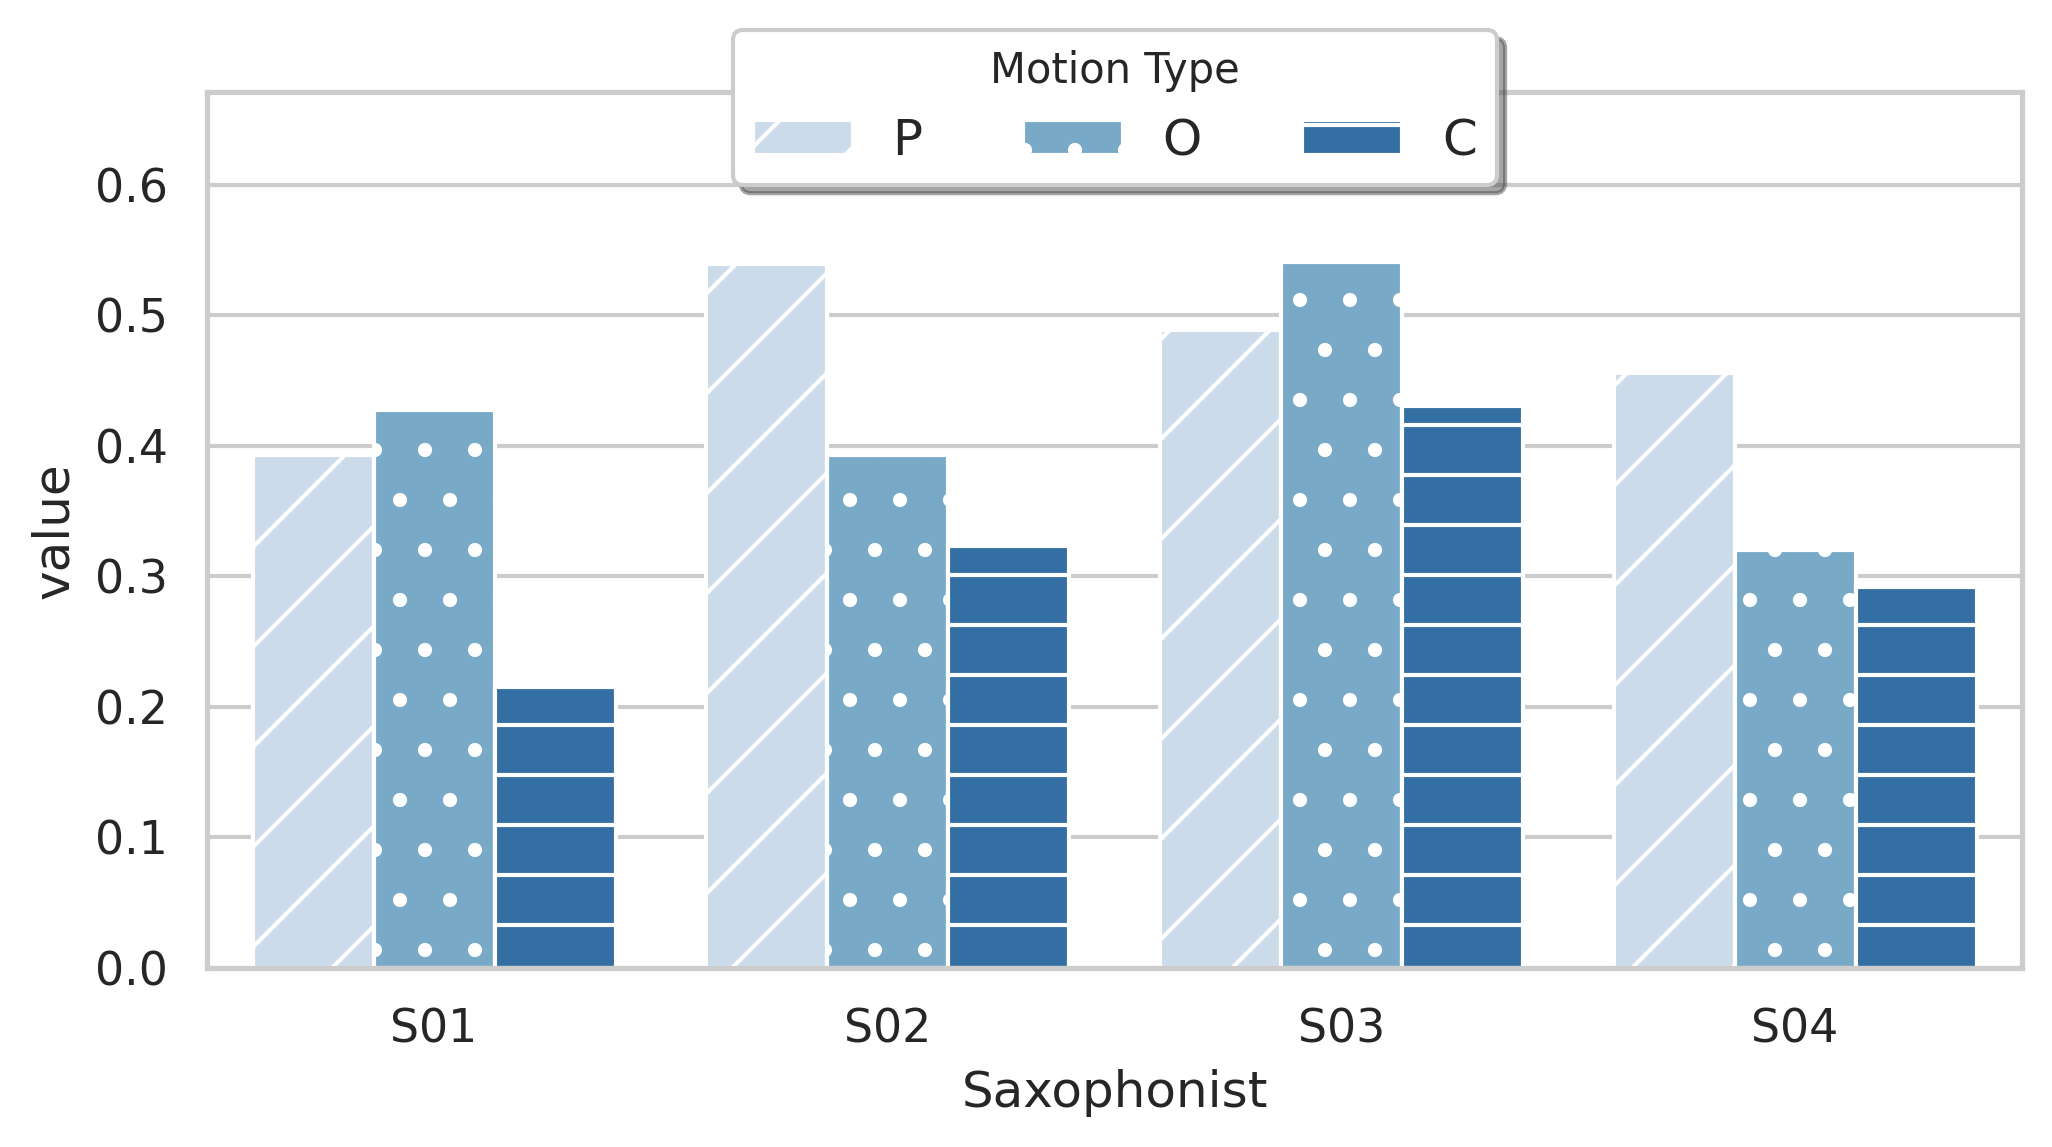

In [334]:
# @title Plot

%matplotlib inline

df_to_plot = pd.DataFrame(columns=['label', 'saxophonist', 'motion', 'phrase', 'value'])

for row in mixed_df.stack().iterrows():
  label, phrase = row[0]

  for col in row[1].items():
    if not np.isnan(col[1]):
      df_to_plot.loc[len(df_to_plot)] = [label, col[0], label[0], phrase.split(' ')[-1], col[1]]


import seaborn as sns
sns.set(style='whitegrid', color_codes=True)

fig, ax = plt.subplots(figsize=(7, 4), dpi=300)

sns.barplot(data=df_to_plot, x='saxophonist', y='value', hue='motion', palette='Blues', errwidth=0, ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fancybox=True, shadow=True, title='Motion Type', fontsize='medium', title_fontsize='small')

ax.set_xlabel('Saxophonist')

hatches = ['/', '.', '-', '\\']
for container, hatch, handle in zip(ax.containers, hatches, ax.get_legend().legend_handles):
  handle.set_hatch(hatch)
  for rectangle in container:
    rectangle.set_hatch(hatch)

plt.tight_layout()
plt.show()

## Tests

In [ ]:
#@title Testing Algorithms

original_jorge = df.xs(('OR', 'T01'), level=('Phrase', 'Tester'))
to_test = df.xs(('OR', 'T04'), level=('Phrase', 'Tester')).values

"""
#print(generate_correlation_map(original_jorge, to_test))
print(get_euclidean_distance(original_jorge, to_test))
print(get_procrustes_distance(original_jorge, to_test))
print(get_principal_components(original_jorge, to_test, 4))
print(get_fourier_descriptors(original_jorge, to_test))
print(get_angular_distance_between_shapes(original_jorge, to_test))
print(get_betti_numbers_and_persistent_homology(original_jorge, 100, 3))
print(get_betti_numbers_and_persistent_homology(to_test, 100, 3))

predictions1 = get_dimensionality_reduction('tsne', original_jorge, 3)
predictions2 = get_dimensionality_reduction('tsne', to_test, 3)
best_error, best_angle = get_optimal_alignment_rotation(predictions1, predictions2, axis='z', angle_range=(0, 360), step_size=10)
#plot_best_alignment(predictions1, predictions2, best_angle, axis='z')
translated_shape1, translation_error = get_optimal_alignment_translation(predictions1, predictions2, translate_to_centroid=True)
print(translation_error)
"""
from scipy.stats import pearsonr
print(original_jorge.shape)
print(to_test.shape)


# Dataset (Description most important)

# Statistical Description of dataset and Pre-analysis

# Correlation (Mantem shape)
# Distancia Angular (Centroid e pontos) -> direcionalidade
# Distancia euclidean



(88, 16)
(88, 16)


PearsonRResult(statistic=0.5456246475467923, pvalue=4.9313725029324644e-110)